# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_squared_log_error, make_scorer, explained_variance_score, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, power_transform, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, SelectPercentile
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/seoul-bike-rental-ai-pro-iti/sample_submission.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/test.csv


# Loading the data

In [2]:
df_train = pd.read_csv('/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv', index_col=0)
df_test = pd.read_csv('/kaggle/input/seoul-bike-rental-ai-pro-iti/test.csv', index_col=0)

df_train.rename(columns={"Temperature(�C)": "Temperature (C)",
                   "Dew point temperature(�C)": "Dew point temperature (C)"}, inplace= True)
df_test.rename(columns={"Temperature(�C)": "Temperature (C)",
                   "Dew point temperature(�C)": "Dew point temperature (C)"}, inplace= True)

df_test.head()

,Date,Hour,Temperature (C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
ID,,,,,,,,,,,,,
5760,21/12/2017,0,-1.3,90,2.0,259,-2.7,0.0,0.0,2.2,Winter,No Holiday,Yes
5761,21/12/2017,1,-1.8,90,1.6,263,-3.2,0.0,0.0,2.2,Winter,No Holiday,Yes
5762,21/12/2017,2,-2.2,88,1.4,348,-3.9,0.0,0.0,2.2,Winter,No Holiday,Yes
5763,21/12/2017,3,-2.9,89,1.3,288,-4.4,0.0,0.0,2.2,Winter,No Holiday,Yes
5764,21/12/2017,4,-3.6,91,1.2,241,-4.8,0.0,0.0,2.2,Winter,No Holiday,Yes


In [3]:
df_train.head()

,Date,y,Hour,Temperature (C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
ID,,,,,,,,,,,,,,
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train['Year'] = df_train['Date'].dt.year
df_train['Month'] = df_train['Date'].dt.month
df_train['Day'] = df_train['Date'].dt.day

df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['Year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day

### Learning more about the data

In [5]:
df_train.describe()

,y,Hour,Temperature (C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Year,Month,Day
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,703.483854,11.500000,12.803559,58.361806,1.723333,1473.711458,4.058264,0.572325,0.135122,0.046302,2017.916667,6.500000,10.500000
std,655.249491,6.922788,11.902206,19.840167,1.047898,585.879880,13.003582,0.869943,1.075320,0.323728,0.276409,3.452352,5.766782
min,0.000000,0.000000,-15.100000,0.000000,0.000000,27.000000,-26.900000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000
25%,188.000000,5.750000,3.200000,43.000000,0.900000,1025.750000,-5.400000,0.000000,0.000000,0.000000,2018.000000,3.750000,5.750000
50%,485.500000,11.500000,13.700000,57.000000,1.500000,1732.000000,5.200000,0.010000,0.000000,0.000000,2018.000000,6.500000,10.500000
75%,1066.000000,17.250000,22.225000,73.000000,2.300000,2000.000000,14.700000,0.940000,0.000000,0.000000,2018.000000,9.250000,15.250000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000,2018.000000,12.000000,20.000000


In [6]:
df_train.dtypes

Date                         datetime64[ns]
y                                     int64
Hour                                  int64
Temperature (C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature (C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
Year                                  int64
Month                                 int64
Day                                   int64
dtype: object

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='y'>

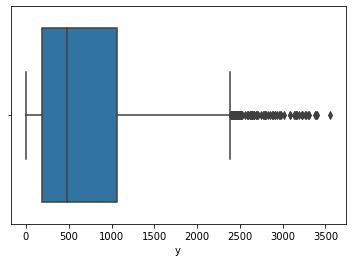

In [7]:
sns.boxplot(df_train['y'])

### Number of rows and columns

In [8]:
print('Rows and Columns in train dataset:', df_train.shape)
print('Rows and Columns in test dataset:', df_test.shape)

Rows and Columns in train dataset: (5760, 17)
Rows and Columns in test dataset: (3000, 16)


### Number of missing values

In [9]:
print('Missing values in train dataset:', df_train.isna().sum()) 
print('-----------------------------------')
print('Missing values in test dataset:', df_test.isna().sum())

Missing values in train dataset: Date                         0
y                            0
Hour                         0
Temperature (C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature (C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
Year                         0
Month                        0
Day                          0
dtype: int64
-----------------------------------
Missing values in test dataset: Date                         0
Hour                         0
Temperature (C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature (C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday           

# Bootstraping (Not used for now)

In [10]:
# df_train.hist(histtype='step', figsize=[15, 15])

In [11]:
# Not all of them has a recognizable simple form, thus we cant build a confidence interval by 
# simulating the sampling distribution because we dont know how to describe thme

In [12]:
# Lets estimate the uncertainty of our statistic (the mean) by generating a large family of samples 
# from the one we have, then characterizing the distribution of the mean of this family 

In [13]:
#df.sample(5760, replace=True).describe()
#dfx= df.drop(columns='Date')

In [14]:
# use random_state for reproducibility

In [15]:
# bootstrap= [df_train.sample(len(df_train), replace= True) for i in range(1000)]

In [16]:
# bootstrap_conf_Intervals= [bootstrap[i].mean() for i in range(len(bootstrap))]

In [17]:
# dfx = pd.DataFrame.from_dict(map(dict,bootstrap_conf_Intervals))

In [18]:
# [plt.axvline(i, color= 'r') for i in df_train.mean()]
# dfx.hist(histtype='step', figsize=[15, 15])


In [19]:
# dfx['y'].hist(histtype='step', figsize=[6, 6])
# plt.axvline(df_train['y'].mean(), color= 'r')

In [20]:
# print(dfx.quantile(0.025))
# print(dfx.quantile(0.975))

In [21]:
# df_train.duplicated().sum()

In [22]:
# bootstrap[0].duplicated().sum(), bootstrap[7].duplicated().sum(), bootstrap[420].duplicated().sum()  

In [23]:
# bootstrap[0]['y'].hist(histtype= 'step')
# bootstrap[7]['y'].hist(histtype= 'step')
# bootstrap[35]['y'].hist(histtype= 'step')
# bootstrap[420]['y'].hist(histtype= 'step')

In [24]:
# bootstrap[0]['Temperature (C)'].hist(histtype= 'step')
# bootstrap[7]['Temperature (C)'].hist(histtype= 'step')
# bootstrap[35]['Temperature (C)'].hist(histtype= 'step')
# bootstrap[420]['Temperature (C)'].hist(histtype= 'step')

# Feature Selection and Statistical Analysis

In [25]:
numerical_features= ['Hour', 'Temperature (C)', 'Humidity(%)', 'Wind speed (m/s)',
              'Visibility (10m)', 'Dew point temperature (C)',
              'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Year', 'Month', 'Day']

categorical_features= ['Seasons', 'Holiday', 'Functioning Day']

## Numerical Distribution

### Numerical features distribution on train 

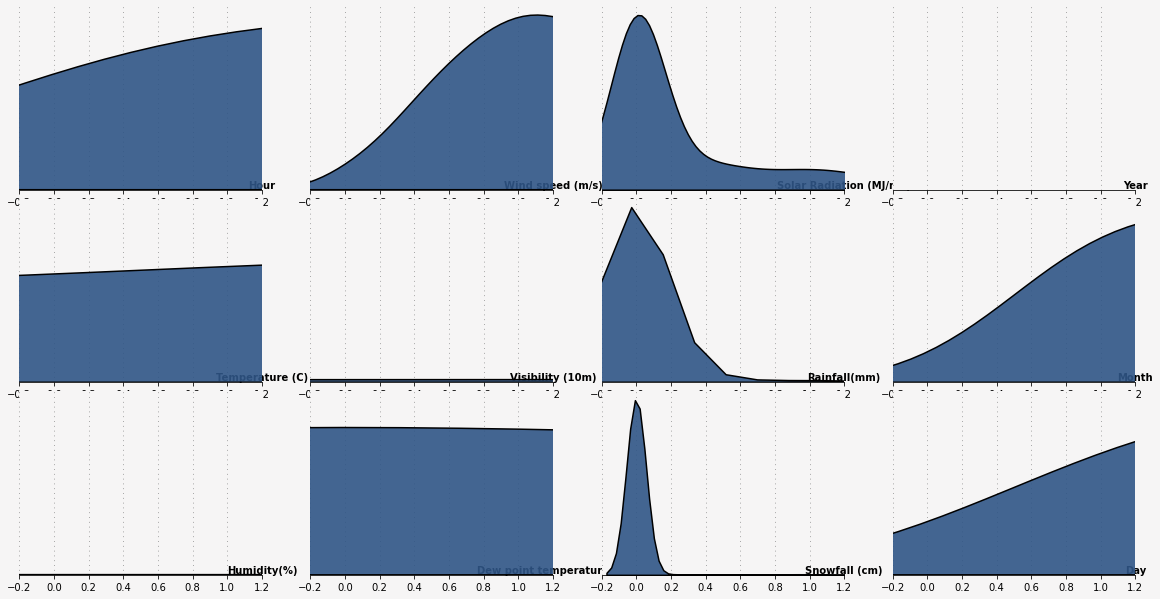

In [26]:
fig = plt.figure(figsize=(20, 14), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 4):
    for row in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

run_no = 0
for col in numerical_features:
    sns.kdeplot(df_train[col], ax=locals()["ax"+str(run_no)], shade=True, color='#2f5586',
                edgecolor='black', linewidth=1.5, alpha=0.9, zorder=3)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray',
                                    linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1

### Numerical features distribution on test

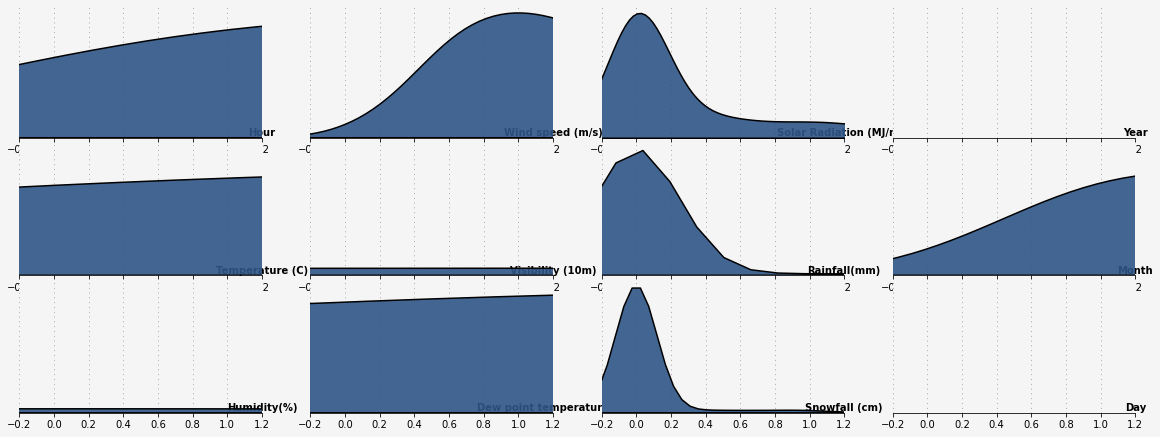

In [27]:
fig = plt.figure(figsize=(20, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 4):
    for row in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

run_no = 0
for col in numerical_features:
    sns.kdeplot(df_test[col], ax=locals()["ax"+str(run_no)], shade=True, color='#2f5586',
                edgecolor='black', linewidth=1.5, alpha=0.9, zorder=3)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray',
                                    linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1

### Target distibution in train

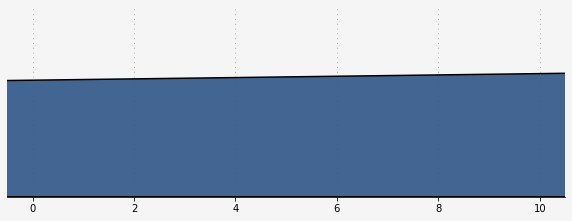

In [28]:
fig = plt.figure(figsize=(10, 3.5), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)
ax0.set_yticklabels([])
ax0.tick_params(axis='y', which=u'both',length=0)
for s in ["top","right", 'left']:
    ax0.spines[s].set_visible(False)

sns.kdeplot(df_train['y'], ax=ax0, shade=True, color='#2f5586', edgecolor='black',
            linewidth=1.5, alpha=0.9, zorder=3)
ax0.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax0.set_xlim(-0.5, 10.5)
ax0.set_xlabel('')
ax0.set_ylabel('')

plt.show()

## Categorical Distribution

### Categorical features count on train

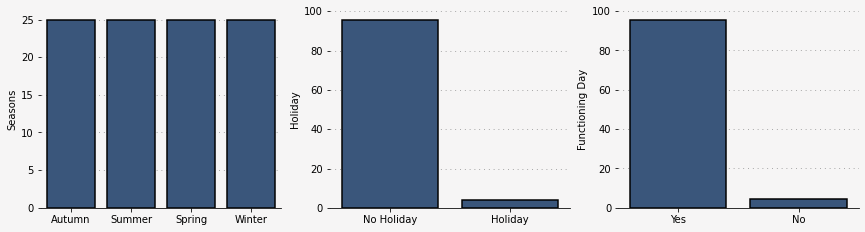

In [29]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(25, 8), facecolor=background_color)
gs = fig.add_gridspec(2, 5)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for col in range(0, 3):
    locals()["ax"+str(run_no)] = fig.add_subplot(gs[0, col])
    locals()["ax"+str(run_no)].set_facecolor(background_color)
    for s in ["top","right", 'left']:
        locals()["ax"+str(run_no)].spines[s].set_visible(False)
    run_no += 1

run_no = 0
for col in categorical_features:
    chart_df = pd.DataFrame(df_train[col].value_counts() / len(df_train) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)],
                color='#2f5586', zorder=3, edgecolor='black', linewidth=1.5)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray',
                                    linestyle=':', dashes=(1,5))
    run_no += 1

### Categorical features count on test

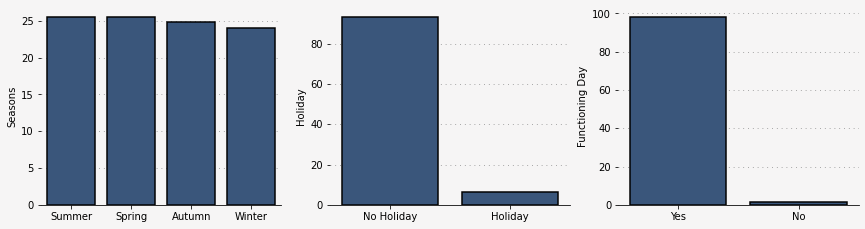

In [30]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(25, 8), facecolor=background_color)
gs = fig.add_gridspec(2, 5)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for col in range(0, 3):
    locals()["ax"+str(run_no)] = fig.add_subplot(gs[0, col])
    locals()["ax"+str(run_no)].set_facecolor(background_color)
    for s in ["top","right", 'left']:
        locals()["ax"+str(run_no)].spines[s].set_visible(False)
    run_no += 1

run_no = 0
for col in categorical_features:
    chart_df = pd.DataFrame(df_test[col].value_counts() / len(df_test) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)],
                color='#2f5586', zorder=3, edgecolor='black', linewidth=1.5)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray',
                                    linestyle=':', dashes=(1,5))
    run_no += 1

## Feature Correlation

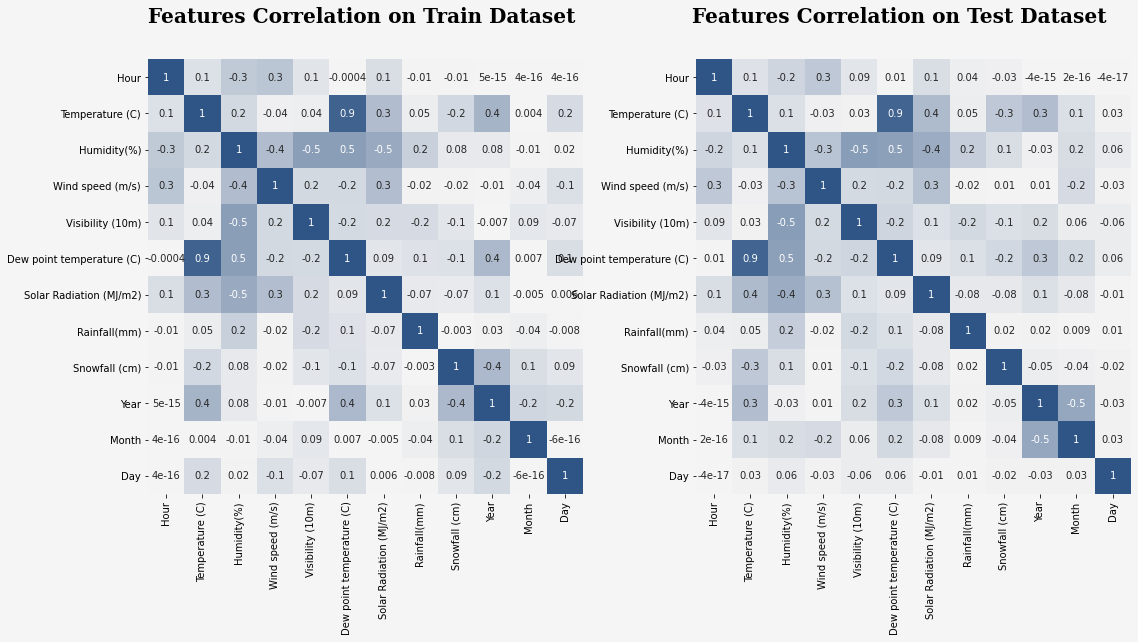

In [31]:
import matplotlib

background_color = "#f6f5f5"

fig = plt.figure(figsize=(18, 8), facecolor=background_color)
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
colors = ["#2f5586", "#f6f5f5","#2f5586"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

ax0.set_facecolor(background_color)
ax0.text(0, -1, 'Features Correlation on Train Dataset', fontsize=20, fontweight='bold',
         fontfamily='serif')
ax1.set_facecolor(background_color)
ax1.text(-0.1, -1, 'Features Correlation on Test Dataset', fontsize=20, fontweight='bold',
         fontfamily='serif')


sns.heatmap(df_train[numerical_features].corr(), ax=ax0, vmin=-1, vmax=1, annot=True, square=True, 
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g')

sns.heatmap(df_test[numerical_features].corr(), ax=ax1, vmin=-1, vmax=1, annot=True, square=True, 
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g')


plt.show()

## Feature Visualization

### Feature Engineering

An overview about the entire data distribution

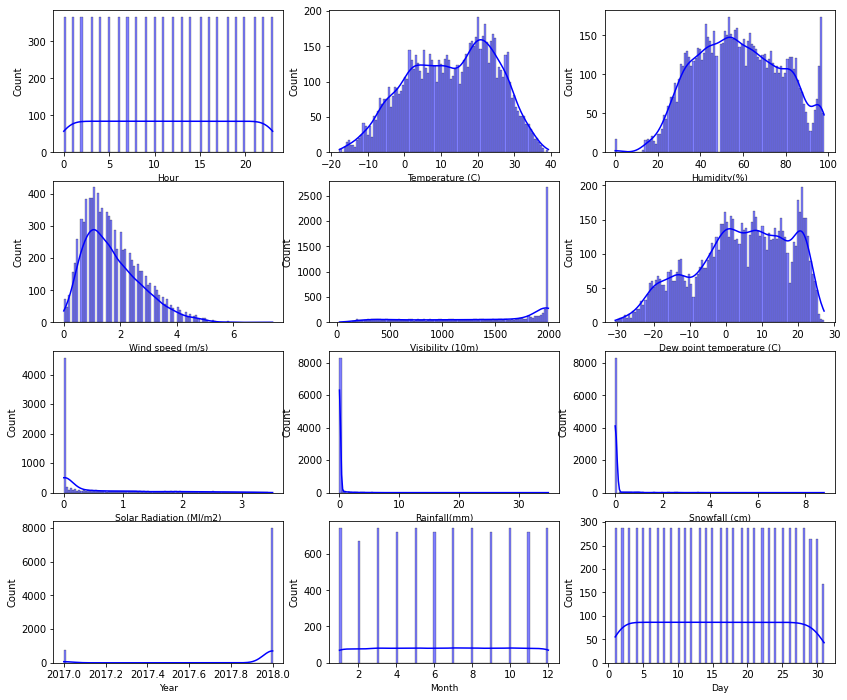

In [32]:
all_data = pd.concat([df_train, df_test])

fig, ax = plt.subplots(4, 4, figsize=(14, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i+1)
    sns.histplot(all_data[feature], 
                 color="blue", 
                 kde=True, 
                 bins=100)
    plt.xlabel(feature, fontsize=9)
plt.show()

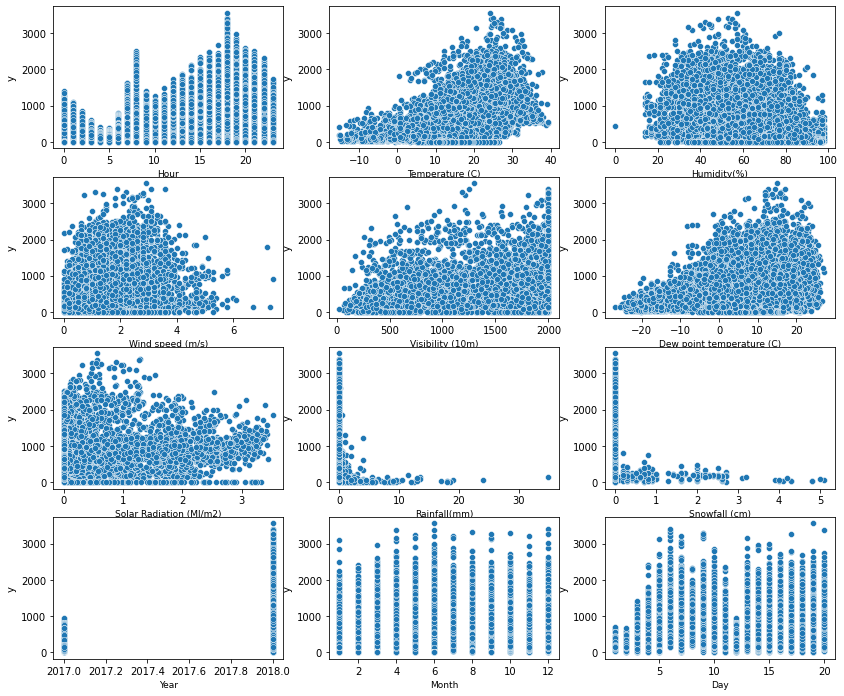

In [33]:
fig, ax = plt.subplots(4, 4, figsize=(14, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i+1)
    sns.scatterplot(x=feature, 
                    y="y", 
                    data=df_train, 
                    palette='muted')
    plt.xlabel(feature, fontsize=9)
plt.show()

# Data Preparation

In [34]:
y= df_train['y']** 0.05
features= df_train.drop(['y', 'Dew point temperature (C)',
                        'Day'], axis= 1)
features['Rain_n_Snow'] = (features['Rainfall(mm)'] > 2.5) & (features['Snowfall (cm)'] > 0.5)
features['is_Night'] = ((features.Hour > 20) | (features.Hour < 5)).astype('int')
features['Snowfall (cm)'], features['Rainfall(mm)'] = np.log(np.clip(df_train['Snowfall (cm)'], 1e-7, None)), np.log(np.clip(df_train['Rainfall(mm)'], 1e-7, None))
features['Solar Radiation (MJ/m2)'] = df_train['Solar Radiation (MJ/m2)'] ** 0.6
features['Visibility (10m)']= np.log(np.clip(df_train['Visibility (10m)'], 1e-7, None))
features['Humidity(%)']= np.log(np.clip(df_train['Humidity(%)'], 1e-7, None))
features.head()

,Date,Hour,Temperature (C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Rain_n_Snow,is_Night
ID,,,,,,,,,,,,,,,,
0,2017-01-12,0,-5.2,3.610918,2.2,7.600902,0.0,-16.118096,-16.118096,Winter,No Holiday,Yes,2017,1,False,1
1,2017-01-12,1,-5.5,3.637586,0.8,7.600902,0.0,-16.118096,-16.118096,Winter,No Holiday,Yes,2017,1,False,1
2,2017-01-12,2,-6.0,3.663562,1.0,7.600902,0.0,-16.118096,-16.118096,Winter,No Holiday,Yes,2017,1,False,1
3,2017-01-12,3,-6.2,3.688879,0.9,7.600902,0.0,-16.118096,-16.118096,Winter,No Holiday,Yes,2017,1,False,1
4,2017-01-12,4,-6.0,3.583519,2.3,7.600902,0.0,-16.118096,-16.118096,Winter,No Holiday,Yes,2017,1,False,1


In [35]:
new_numerical_features= ['Temperature (C)', 'Humidity(%)', 'Wind speed (m/s)',
                         'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
                         'Snowfall (cm)', 'is_Night', 'Hour', 'Month', 'Year']

new_categorical_features= ['Seasons', 'Holiday', 'Functioning Day', 'Rain_n_Snow']

In [36]:
# plt.figure(figsize=(18, 8))
# sns.histplot(features[new_numerical_features])

In [37]:
numerical_transformer_steps = [
    ('imputer', SimpleImputer(strategy= 'median')),
    ('scaler', StandardScaler())]
numerical_transformer= Pipeline(steps= numerical_transformer_steps)


categorical_transformer_steps= [
    ('imputer', SimpleImputer(strategy= 'constant', fill_value= 'missing')),
    ('onehot', OneHotEncoder(handle_unknown= 'ignore'))
]
categorical_transformer= Pipeline(steps= categorical_transformer_steps)


col_transformers= [
    ('num', numerical_transformer, new_numerical_features),
    ('cat', categorical_transformer, new_categorical_features)
]
preprocessor= ColumnTransformer(transformers= col_transformers)


# Modeling

## Breaking the train to train and validation

In [38]:
X_train, X_val, y_train, y_val= train_test_split(features, y, test_size= 0.2, random_state= 12)

## Random Forst

need hyperparameter tuning gridsearchCV

In [39]:
model_rf = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)


In [40]:
model_pipeline_rf= Pipeline(steps= [
    ('preprocessor', preprocessor),
    ('regression', model_rf)
])

In [41]:
model_pipeline_rf.fit(X_train, y_train)
preds_val_rf = model_pipeline_rf.predict(X_val)
rmsle = np.sqrt(mean_squared_log_error(y_val ** (1/0.09), preds_val_rf ** (1/0.09)))
print('rmsle:', rmsle)
mse = mean_squared_error(y_val ** (1/0.09), preds_val_rf ** (1/0.09))
print('mse:', mse)

rmsle: 0.20126989815737592
mse: 34.20747229010212


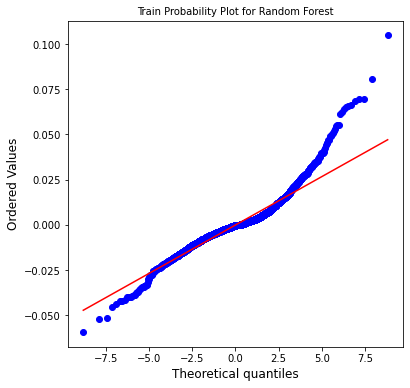

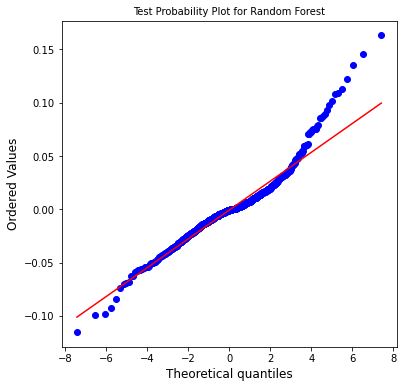

In [42]:
plt.rcParams["axes.labelsize"] = 12
rf_prob_train = model_pipeline_rf.predict(X_train) - y_train
plt.figure(figsize=(6,6))
sp.stats.probplot(rf_prob_train, dist="logistic", plot=plt, fit=True)
plt.title('Train Probability Plot for Random Forest', fontsize=10)
plt.show()

rf_prob_test = model_pipeline_rf.predict(X_val) - y_val
plt.figure(figsize=(6,6))
sp.stats.probplot(rf_prob_test, dist="logistic", plot=plt, fit=True)
plt.title('Test Probability Plot for Random Forest', fontsize=10)
plt.show()

## Extra Tree (Odd behavior!)

In [43]:
efg = ExtraTreesRegressor()

In [44]:
efg_param= {
    'n_estimators' : [3, 4, 5, 20],
    'criterion' : ['mse', 'mae'],
    'max_depth' : [1, 2, 4]
}

In [45]:
scorer = make_scorer(mean_squared_log_error, greater_is_better = False)
efg_grid = GridSearchCV(estimator=efg, param_grid=efg_param, scoring= scorer, cv=5) # , scoring= scorer @ 1.2 rmsle, 175k mse

In [46]:
model_pipeline_efg= Pipeline(steps= [
    ('preprocessor', preprocessor),
    ('regression', efg_grid)
])

In [47]:
model_pipeline_efg.fit(X_train, y_train)
preds_val_efg = model_pipeline_efg.predict(X_val)
rmsle = np.sqrt(mean_squared_log_error(y_val ** (1/0.09), preds_val_efg ** (1/0.09)))
print('rmsle:', rmsle)
mse = mean_squared_error(y_val ** (1/0.09), preds_val_efg ** (1/0.09))
print('mse:', mse)

rmsle: 0.3738100259823147
mse: 129.04980226596794


In [48]:
best_param = efg_grid.best_params_
best_param

{'criterion': 'mae', 'max_depth': 4, 'n_estimators': 20}

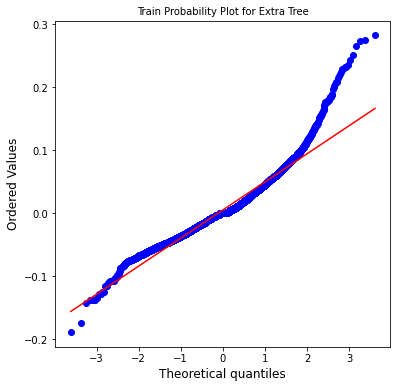

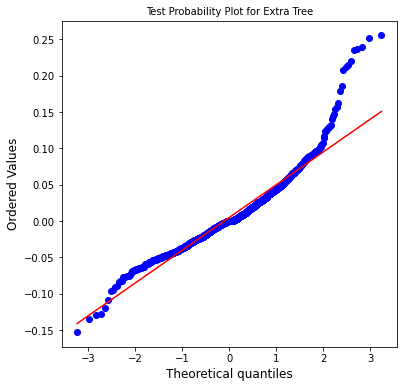

In [49]:
plt.rcParams["axes.labelsize"] = 12
efg_prob_train = model_pipeline_efg.predict(X_train) - y_train
plt.figure(figsize=(6,6))
sp.stats.probplot(efg_prob_train, plot=plt, fit=True)
plt.title('Train Probability Plot for Extra Tree', fontsize=10)
plt.show()

efg_prob_test = model_pipeline_efg.predict(X_val) - y_val
plt.figure(figsize=(6,6))
sp.stats.probplot(efg_prob_test, plot=plt, fit=True)
plt.title('Test Probability Plot for Extra Tree', fontsize=10)
plt.show()

## XGBoost (Not Optimized)

In [50]:
xgb_params = {'objective': 'reg:squarederror',
              'n_estimators': 10000,
              'learning_rate': 0.05,
              'subsample': 0.9,
              'grow_policy':'depthwise',
              'max_depth': 3,
              'booster': 'gbtree', 
              'reg_lambda': 45.1,
              'reg_alpha': 34.9,
              'random_state': 42,
              'reg_lambda': 0.00087,
              'reg_alpha': 23.13181079976304,
              'n_jobs': -1}

model_XGB = XGBRegressor(**xgb_params)

In [51]:
model_pipeline_XGB= Pipeline(steps= [
    ('preprocessor', preprocessor),
    ('regression', model_XGB)
])

In [52]:
model_pipeline_XGB.fit(X_train, y_train)
preds_val_XGB = model_pipeline_XGB.predict(X_val)
preds_val_XGB[preds_val_XGB < 0] = 0

rmsle = np.sqrt(mean_squared_log_error(y_val ** (1/0.09), preds_val_XGB ** (1/0.09)))
print('rmsle:', rmsle)
mse = mean_squared_error(y_val ** (1/0.09), preds_val_XGB ** (1/0.09))
print('mse:', mse)

rmsle: 0.3069753837179533
mse: 111.3065670724512


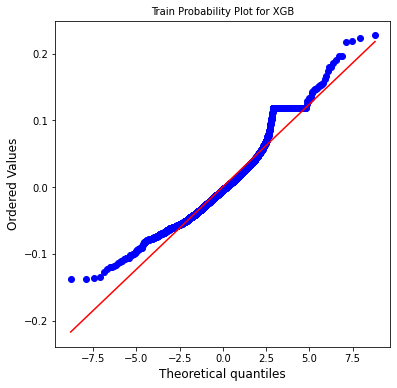

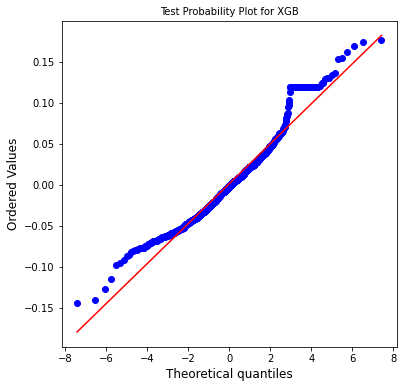

In [53]:
plt.rcParams["axes.labelsize"] = 12
XGB_prob_train = model_pipeline_XGB.predict(X_train) - y_train
plt.figure(figsize=(6,6))
sp.stats.probplot(XGB_prob_train, dist="logistic", plot=plt, fit=True)
plt.title('Train Probability Plot for XGB', fontsize=10)
plt.show()

XGB_prob_test = model_pipeline_XGB.predict(X_val) - y_val
plt.figure(figsize=(6,6))
sp.stats.probplot(XGB_prob_test, dist="logistic", plot=plt, fit=True)
plt.title('Test Probability Plot for XGB', fontsize=10)
plt.show()

## LightGBM (Not Optimized)

In [54]:
lgbm_parameters = {
    'metric': 'RMSE',
    'feature_pre_filter': False,
    'lambda_l1': 0.45,
    'lambda_l2': 4.8,
    'learning_rate': 0.005,
    'num_trees': 80000,
    'num_leaves': 10, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 1.0, 
    'bagging_freq': 0, 
    'min_child_samples': 100,
    'num_threads': 4
}

lgbm_model = LGBMRegressor(**lgbm_parameters)

In [55]:
model_pipeline_LGBM= Pipeline(steps= [
    ('preprocessor', preprocessor),
    ('regression', lgbm_model)
])

In [56]:
model_pipeline_LGBM.fit(X_train, y_train)
preds_val_LGBM = model_pipeline_LGBM.predict(X_val)
preds_val_LGBM[preds_val_LGBM < 0] = 0
rmsle = np.sqrt(mean_squared_log_error(y_val, preds_val_LGBM))
print('rmsle:', rmsle)
mse = mean_squared_error(y_val, preds_val_LGBM)
print('mse:', mse)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] lambda_l1 is set=0.45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] num_iterations is set=80000, num_trees=80000 will be ignored. Current value: num_iterations=80000
rmsle: 0.01245784393645149
mse: 0.0007744268713121075


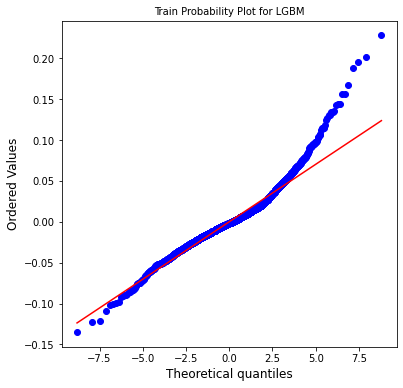

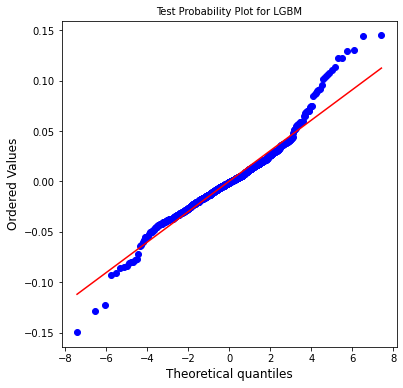

In [57]:
plt.rcParams["axes.labelsize"] = 12
LGBM_prob_train = model_pipeline_LGBM.predict(X_train) - y_train
plt.figure(figsize=(6,6))
sp.stats.probplot(LGBM_prob_train, dist="logistic", plot=plt, fit=True)
plt.title('Train Probability Plot for LGBM', fontsize=10)
plt.show()

LGBM_prob_test = model_pipeline_LGBM.predict(X_val) - y_val
plt.figure(figsize=(6,6))
sp.stats.probplot(LGBM_prob_test, dist="logistic", plot=plt, fit=True)
plt.title('Test Probability Plot for LGBM', fontsize=10)
plt.show()

## CatBoost

{'bootstrap_type': 'Bernoulli',
 'eval_metric': 'RMSE',
 'grow_policy': 'Depthwise',
 'iterations': 2000,
 'l2_leaf_reg': 20,
 'leaf_estimation_method': 'Gradient',
 'learning_rate': 0.08,
 'loss_function': 'RMSE',
 'od_type': 'Iter',
 'random_seed': 42,
 'random_strength': 1e-20,
 'thread_count': 4,
 'verbose': False}

In [58]:
cat_parameters = {    
    'iterations':2000,
    'learning_rate':0.08,
    'l2_leaf_reg':10,
    'random_strength': 1e-20,  # np.logspace(-20, -19, 3)
    'grow_policy':'Depthwise',
    'leaf_estimation_method':'Gradient', 
    'bootstrap_type':'Bernoulli',
    'thread_count':4,
    'verbose':False,
    'loss_function':'RMSE',
    'eval_metric':'RMSE',
    'od_type':'Iter',
    'random_seed':12
}

cat_model = CatBoostRegressor(**cat_parameters) 

In [59]:
# cat_model = CatBoostRegressor()

# scorer = make_scorer(mean_squared_error, greater_is_better = False) 
# cant use mean_squared_log_error here because of -ve 

# cat_model_grid = GridSearchCV(estimator=cat_model, param_grid=cat_parameters, scoring= scorer, cv=5)

In [60]:
model_pipeline_cat= Pipeline(steps= [
    ('preprocessor', preprocessor),
    ('regression', cat_model)
])

In [61]:
model_pipeline_cat.fit(X_train, y_train)
preds_val_cat = model_pipeline_cat.predict(X_val)
preds_val_cat[preds_val_cat < 0] = 0

rmsle = np.sqrt(mean_squared_log_error(y_val ** (1/0.05), preds_val_cat ** (1/0.05)))
print('rmsle:', rmsle)
mse = mean_squared_error(y_val ** (1/0.05), preds_val_cat ** (1/0.05))
print('mse:', mse)

rmsle: 0.34281040408426966
mse: 37936.63404734171


In [62]:
# best_param = cat_model_grid.best_params_
# best_param

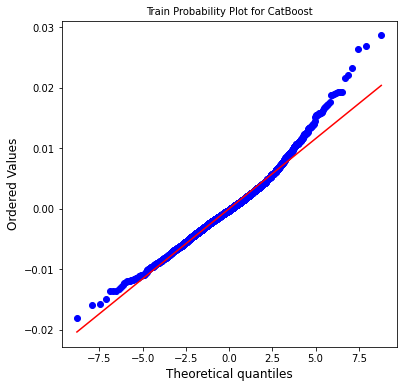

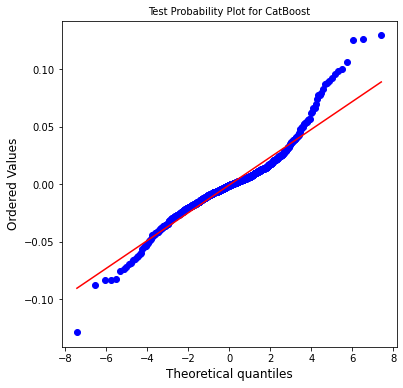

In [63]:
plt.rcParams["axes.labelsize"] = 12
cat_prob_train = model_pipeline_cat.predict(X_train) - y_train
plt.figure(figsize=(6,6))
sp.stats.probplot(cat_prob_train, dist="logistic", plot=plt, fit=True)
plt.title('Train Probability Plot for CatBoost', fontsize=10)
plt.show()

cat_prob_test = model_pipeline_cat.predict(X_val) - y_val
plt.figure(figsize=(6,6))
sp.stats.probplot(cat_prob_test, dist="logistic", plot=plt, fit=True)
plt.title('Test Probability Plot for CatBoost', fontsize=10)
plt.show()

In [64]:
test_feat= df_test.drop(['Day', 'Dew point temperature (C)'], axis= 1)
test_feat['Rain_n_Snow'] = (test_feat['Rainfall(mm)'] > 2.5) & (test_feat['Snowfall (cm)'] > 0.5)
test_feat['is_Night'] = ((test_feat.Hour > 20) | (test_feat.Hour < 5)).astype('int')
test_feat['Snowfall (cm)'], test_feat['Rainfall(mm)'] = np.log(np.clip(df_test['Snowfall (cm)'], 1e-7, None)), np.log(np.clip(df_test['Rainfall(mm)'], 1e-7, None))
test_feat['Solar Radiation (MJ/m2)'] = df_test['Solar Radiation (MJ/m2)'] ** 0.6
test_feat['Visibility (10m)']= np.log(np.clip(df_test['Visibility (10m)'], 1e-7, None))
test_feat['Humidity(%)']= np.log(np.clip(df_test['Humidity(%)'], 1e-7, None))

test_feat.head()

,Date,Hour,Temperature (C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Rain_n_Snow,is_Night
ID,,,,,,,,,,,,,,,,
5760,2017-12-21,0,-1.3,4.499810,2.0,5.556828,0.0,-16.118096,0.788457,Winter,No Holiday,Yes,2017,12,False,1
5761,2017-12-21,1,-1.8,4.499810,1.6,5.572154,0.0,-16.118096,0.788457,Winter,No Holiday,Yes,2017,12,False,1
5762,2017-12-21,2,-2.2,4.477337,1.4,5.852202,0.0,-16.118096,0.788457,Winter,No Holiday,Yes,2017,12,False,1
5763,2017-12-21,3,-2.9,4.488636,1.3,5.662960,0.0,-16.118096,0.788457,Winter,No Holiday,Yes,2017,12,False,1
5764,2017-12-21,4,-3.6,4.510860,1.2,5.484797,0.0,-16.118096,0.788457,Winter,No Holiday,Yes,2017,12,False,1


In [65]:
y_cat_preds = model_pipeline_cat.predict(test_feat)
y_cat_preds[y_cat_preds < 0] = 0
y_final= y_cat_preds ** (1 / 0.05)

test_feat['y'] = y_final
#test_feat[['ID', 'y']].to_csv('/kaggle/working/submission.csv', index=False)

In [66]:
test_feat[['y']].to_csv('/kaggle/working/submission_final.csv', index=True)

# ANOVA or t-test or whatever

In [67]:
# seasons = {'Winter':0,'Spring':1,'Summer':2,'Autumn':3}
# df['Functioning Day'] = df['Functioning Day'].apply(lambda x: 1 if x == 'Yes' else 0)
# df['Holiday'] = df['Holiday'].apply(lambda x: 1 if x == 'Holiday' else 0)
# df.Seasons = df.Seasons.map(seasons)
# df= df.drop(columns='Date')

In [68]:
# X_train, X_test, y_train, y_test= train_test_split(df, y, test_size= 0.2)

In [69]:
# constent_filter= VarianceThreshold(threshold= 0.01)
# constent_filter.fit(X_train)
# X_train_transform= constent_filter.transform(X_train)
# X_test_transform= constent_filter.transform(X_test)

In [70]:
# sel= f_regression(X_train_transform, y_train)
# sel

In [71]:
# p_values= pd.Series(sel[1])
# p_values.index= X_train.columns
# p_values.sort_values(ascending= True, inplace= True)
# p_values= p_values[p_values < 0.05]

In [72]:
# p_values.plot.bar(figsize= (16, 5))

In [73]:
# p_values.index

# Correlation Inspection

In [74]:
# _corr= X_train.corr()
# plt.figure(figsize= (16,9))
# _ = sns.heatmap(_corr)

In [75]:
# def correlations(X, epslion):
#     c= set()
#     corr_mat= X.corr()
#     for i in range(len(corr_mat.columns)):
#         for j in range(i):
#             if abs(corr_mat.iloc[i, j]) > epslion:
#                 col_name= corr_mat.columns[i]
#                 c.add(col_name)
#     return c

# corr_features= correlations(df, 0.85)   # 85% correlated
# corr_features

In [76]:
# corrdata= _corr.abs().stack()
# corrdata= corrdata[corrdata > 0.50]
# corrdata= pd.DataFrame(corrdata).reset_index()
# corrdata.columns= ['Feature 1', 'Feature 2', 'Corr']
# corrdata